<a href="https://colab.research.google.com/github/the-pinbo/image-denoising/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Restoration without Denoised
##Mini Project in Image Processing
##EC386
###Members


1.   
```
Inbasekaran Perumal
201EC226
inba2002.p@gmail.com
```
2.   
```
Pranav Koundinya
201EC241
pranavmkoundinya@gmail.com
```

###Guide
```
Prof. Sumam David S
```


###Course Instructor
```
Prof. Deepu Vijayasenan
```

In [4]:
#@title Mount Drive
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/ImageProcessing/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 1803.04189.pdf  'Image Restoration Without Denoised Priors.docx'   model.png
 dataset	  model.ipynb					    my_model


In [2]:
#@title Tensor flow gpu check
import tensorflow as tf
tf.test.gpu_device_name()

''

To format the code do this 
```
!pip install black[jupyter]
!/content/drive/MyDrive/ImageProcessing/model.ipynb
```



In [7]:
#@title Importing Modules
import os
from matplotlib import image
from shutil import copyfile
import cv2
import seaborn as sns
import random
import PIL
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras import backend as K
import tensorflow as tf
tf.random.set_seed(0)

In [45]:
#@title Loading images
srcPath = "/content/drive/MyDrive/ImageProcessing/dataset" #@param ["/content/drive/MyDrive/ImageProcessing/dataset", "/content/drive/MyDrive/bsd_images/images"] {allow-input: true}
%cd /content/drive/MyDrive/ImageProcessing/dataset
train_scan_paths = os.listdir(srcPath + "/train")
test_scan_paths = os.listdir(srcPath + "/test")

train_scan_paths = [(srcPath + "/train/" + x) for x in train_scan_paths]
test_scan_paths = [(srcPath + "/test/" + x) for x in test_scan_paths]


print("Train scan with length of: {}".format(len(train_scan_paths)))
print(train_scan_paths[:5])
print("test scan with length of: {}".format(len(test_scan_paths)))
print(test_scan_paths[:5])

/content/drive/MyDrive/ImageProcessing/dataset
Train scan with length of: 301
['/content/drive/MyDrive/ImageProcessing/dataset/train/15011.jpg', '/content/drive/MyDrive/ImageProcessing/dataset/train/100007.jpg', '/content/drive/MyDrive/ImageProcessing/dataset/train/16004.jpg', '/content/drive/MyDrive/ImageProcessing/dataset/train/104010.jpg', '/content/drive/MyDrive/ImageProcessing/dataset/train/188025.jpg']
test scan with length of: 99
['/content/drive/MyDrive/ImageProcessing/dataset/test/253036.jpg', '/content/drive/MyDrive/ImageProcessing/dataset/test/187039.jpg', '/content/drive/MyDrive/ImageProcessing/dataset/test/153093.jpg', '/content/drive/MyDrive/ImageProcessing/dataset/test/209070.jpg', '/content/drive/MyDrive/ImageProcessing/dataset/test/317080.jpg']


In [20]:
#@title Preprocessing helper functions 
def normalize_scan(image):

    norm_image = cv2.normalize(
        image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F
    )

    return norm_image


def resize_scan(scan, desired_width, desired_height):

    scan = cv2.resize(scan, (desired_height, desired_width))

    return scan


def preprocess_scan(path, width, height):

    scan = cv2.imread(path)
    resized_scan = resize_scan(scan, width, height)
    normalized_resized_scan = normalize_scan(resized_scan)

    return normalized_resized_scan


def generate_img(image):
    plt.axis("off")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()


def generate_img_2(image):
    img = plt.imshow(image)
    # img.set_cmap('hot')
    plt.axis("off")
    # plt.show()

In [21]:
#@title Define constant width and height
width = 256
height = 256

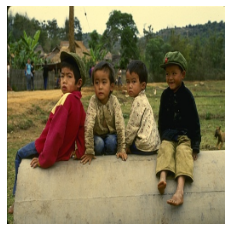

In [22]:
#@title Preprocess images 
train_scans = [preprocess_scan(path, width, height) for path in train_scan_paths]
test_scans = [preprocess_scan(path, width, height) for path in test_scan_paths]
data = train_scans[0]
generate_img(data)

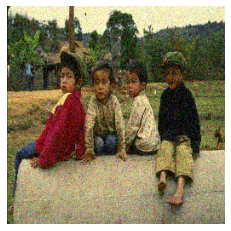

In [29]:
#@title Noise helper functions 
def addGaussNoise(image,mean=0,var=.01):
  row, col, ch = image.shape
  sigma = var**0.5
  gauss = np.random.normal(mean, sigma, (row, col, ch))
  gauss = gauss.reshape(row, col, ch)
  noisy = image + gauss
  return noisy
mean = 0 #@param {type:"number"}
var = .01 #@param {type:"number"}
image = train_scans[0]
noisyimg = addGaussNoise(image,mean,var)
generate_img(noisyimg.astype("float32"))


In [16]:
#@title Adding noise to images before training
train_gaussian_noise_images = np.array([addGaussNoise(x,mean,var) for x in train_scans])
test_gaussian_noise_images = np.array([addGaussNoise(x,mean,var) for x in test_scans])

train_target_images = np.array(train_scans)
test_target_images = np.array(test_scans)

In [ ]:
#@title Defining batch size 
# Batch size
BATCH_SIZE = 128
# Train size
train_gaussian_noise_images.shape

(301, 256, 256, 3)

In [33]:
#@title Importing modules for training 
from tensorflow.keras.losses import MeanSquaredError
mse = tf.keras.losses.MeanSquaredError()
mse(train_gaussian_noise_images[0], train_scans[0]).numpy()
from keras import Input, Model, Sequential
from keras import layers
from keras import backend as K
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers.experimental.preprocessing import (
    RandomFlip,
    RandomContrast,
    RandomRotation,
)
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Add
K.clear_session()

In [31]:
#@title Data augmentation
data_augmentation = Sequential(
    [RandomFlip(mode="horizontal", seed=0), RandomContrast(0.1, seed=0)]
)

In [36]:
#@title U-Net model
def UNet():

    input_img = Input(shape=(256, 256, 3))
    augmentation = data_augmentation(input_img)

    # ============================================================================
    # == ENCODER
    # ============================================================================

    conv_1_a = layers.Conv2D(48, (3, 3), padding="same", use_bias=False)(augmentation)
    l_relu_1_a = layers.LeakyReLU()(conv_1_a)
    conv_1_b = layers.Conv2D(48, (3, 3), padding="same", use_bias=False)(l_relu_1_a)
    l_relu_1_b = layers.LeakyReLU()(conv_1_b)
    maxpool_1 = layers.MaxPooling2D((2, 2), padding="same")(l_relu_1_b)
    print(maxpool_1.shape)

    conv_2 = layers.Conv2D(48, (3, 3), padding="same", use_bias=False)(maxpool_1)
    l_relu_2 = layers.LeakyReLU()(conv_2)
    maxpool_2 = layers.MaxPooling2D((2, 2), padding="same")(l_relu_2)
    print(maxpool_2.shape)

    conv_3 = layers.Conv2D(48, (3, 3), padding="same", use_bias=False)(maxpool_2)
    l_relu_3 = layers.LeakyReLU()(conv_3)
    maxpool_3 = layers.MaxPooling2D((2, 2), padding="same")(l_relu_3)
    print(maxpool_3.shape)

    conv_4 = layers.Conv2D(48, (3, 3), padding="same", use_bias=False)(maxpool_3)
    l_relu_4 = layers.LeakyReLU()(conv_4)
    maxpool_4 = layers.MaxPooling2D((2, 2), padding="same")(l_relu_4)
    print(maxpool_4.shape)

    conv_5_a = layers.Conv2D(48, (3, 3), padding="same", use_bias=False)(maxpool_4)
    l_relu_5_a = layers.LeakyReLU()(conv_5_a)
    maxpool_5 = layers.MaxPooling2D((2, 2), padding="same")(l_relu_5_a)
    print(maxpool_5.shape)

    conv_5_b = layers.Conv2D(48, (3, 3), padding="same", use_bias=False)(maxpool_5)
    encoded = layers.LeakyReLU()(conv_5_b)

    # ============================================================================
    # == DECODER
    # ============================================================================

    upsamp_6 = layers.UpSampling2D((2, 2))(encoded)
    print(upsamp_6.shape)
    concat_6 = tf.concat([upsamp_6, maxpool_4], axis=3)
    print(concat_6.shape)
    conv_6_a = layers.Conv2D(96, (3, 3), padding="same", use_bias=False)(concat_6)
    l_relu_6_a = layers.LeakyReLU()(conv_6_a)
    conv_6_b = layers.Conv2D(96, (3, 3), padding="same", use_bias=False)(l_relu_6_a)
    l_relu_6_b = layers.LeakyReLU()(conv_6_b)

    upsamp_7 = layers.UpSampling2D((2, 2))(l_relu_6_b)
    print(upsamp_7.shape)
    concat_7 = tf.concat([upsamp_7, maxpool_3], axis=3)
    print(concat_7.shape)
    conv_7_a = layers.Conv2D(96, (3, 3), padding="same", use_bias=False)(concat_7)
    l_relu_7_a = layers.LeakyReLU()(conv_7_a)
    conv_7_b = layers.Conv2D(96, (3, 3), padding="same", use_bias=False)(l_relu_7_a)
    l_relu_7_b = layers.LeakyReLU()(conv_7_b)

    upsamp_8 = layers.UpSampling2D((2, 2))(l_relu_7_b)
    print(upsamp_8.shape)
    concat_8 = tf.concat([upsamp_8, maxpool_2], axis=3)
    print(concat_8.shape)
    conv_8_a = layers.Conv2D(96, (3, 3), padding="same", use_bias=False)(concat_8)
    l_relu_8_a = layers.LeakyReLU()(conv_8_a)
    conv_8_b = layers.Conv2D(96, (3, 3), padding="same", use_bias=False)(l_relu_8_a)
    l_relu_8_b = layers.LeakyReLU()(conv_8_b)

    upsamp_9 = layers.UpSampling2D((2, 2))(l_relu_8_b)
    print(upsamp_9.shape)
    concat_9 = tf.concat([upsamp_9, maxpool_1], axis=3)
    print(concat_9.shape)
    conv_9_a = layers.Conv2D(96, (3, 3), padding="same", use_bias=False)(concat_9)
    l_relu_9_a = layers.LeakyReLU()(conv_9_a)
    conv_9_b = layers.Conv2D(96, (3, 3), padding="same", use_bias=False)(l_relu_9_a)
    l_relu_9_b = layers.LeakyReLU()(conv_9_b)

    upsamp_10 = layers.UpSampling2D((2, 2))(l_relu_9_b)
    print(upsamp_10.shape)
    concat_10 = tf.concat([upsamp_10, input_img], axis=3)
    print(concat_10.shape)
    conv_10_a = layers.Conv2D(64, (3, 3), padding="same", use_bias=False)(concat_10)
    l_relu_10_a = layers.LeakyReLU()(conv_10_a)
    conv_10_b = layers.Conv2D(32, (3, 3), padding="same", use_bias=False)(l_relu_10_a)
    l_relu_10_b = layers.LeakyReLU()(conv_10_b)

    decoded = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(
        l_relu_10_b
    )
    print(decoded.shape)

    return Model(input_img, decoded)

In [35]:
#@title Red-Net model
def RedNet():
    il = Input(shape=(256, 256, 3))
    augmentation = data_augmentation(il)

    # ============================================================================
    # == ENCODER
    # ============================================================================

    l1 = Conv2D(
        16,
        (3, 3),
        padding="same",
        activation="relu",
    )(augmentation)
    l2 = Conv2D(16, (3, 3), padding="same", activation="relu")(l1)
    l3 = Conv2D(16, (3, 3), padding="same", activation="relu")(l2)
    l4 = Conv2D(16, (3, 3), padding="same", activation="relu")(l3)
    l5 = Conv2D(16, (3, 3), padding="same", activation="relu")(l4)

    # ============================================================================
    # == DECODER
    # ============================================================================

    l6 = Conv2DTranspose(16, (3, 3), padding="same", activation="relu")(l5)
    s1 = Add()([l6, l4])
    l7 = Conv2DTranspose(16, (3, 3), padding="same", activation="relu")(s1)
    s2 = Add()([l7, l3])
    l8 = Conv2DTranspose(16, (3, 3), padding="same", activation="relu")(s2)
    s3 = Add()([l8, l2])
    l9 = Conv2DTranspose(16, (3, 3), padding="same", activation="relu")(s3)
    s4 = Add()([l9, l1])
    l10 = Conv2DTranspose(3, (3, 3), padding="same", activation="relu")(s4)

    model = Model(il, l10)
    return model

In [37]:
#@title instantiation of model
architecture = "UNet" #@param ["RedNet", "UNet"]
autoencoder = eval(architecture)()

(None, 128, 128, 48)
(None, 64, 64, 48)
(None, 32, 32, 48)
(None, 16, 16, 48)
(None, 8, 8, 48)
(None, 16, 16, 48)
(None, 16, 16, 96)
(None, 32, 32, 96)
(None, 32, 32, 144)
(None, 64, 64, 96)
(None, 64, 64, 144)
(None, 128, 128, 96)
(None, 128, 128, 144)
(None, 256, 256, 96)
(None, 256, 256, 99)
(None, 256, 256, 3)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 48  1296        ['sequential[0][0]']             
                                )                                                                 
                                                                                              

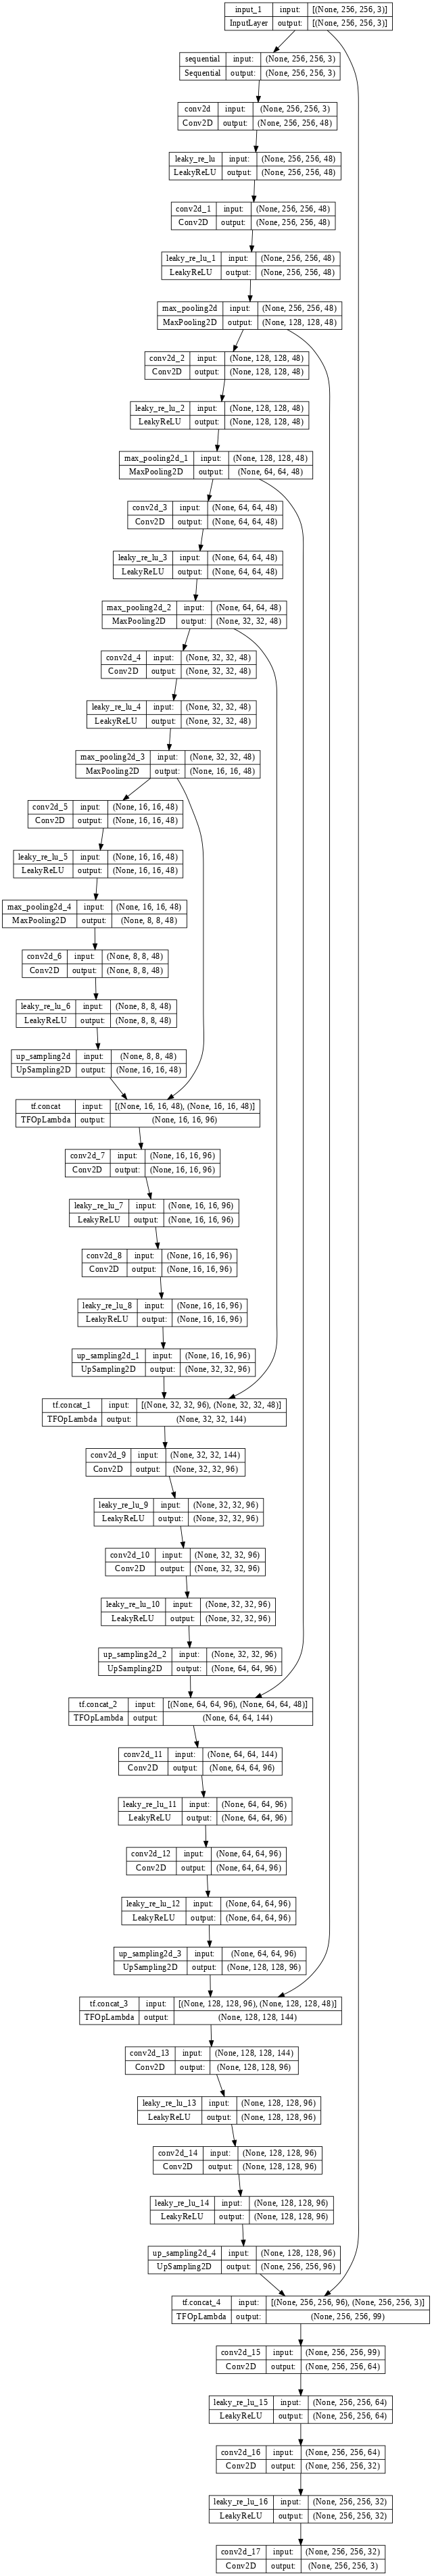

In [39]:
#@title Plot model
from tensorflow.keras.utils import plot_model
autoencoder.summary()
plot_model(autoencoder, show_shapes=True, dpi=64)

In [54]:
#@title Defining optimizers
from tensorflow.keras.optimizers import Adam

autoencoder_optimizer = Adam(0.0001, beta_1=0.9)
autoencoder.compile(optimizer="adam", loss=MeanSquaredError(), metrics=["accuracy"])

In [55]:
#@title Model Checkpoint
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = "my_model/model_gauss_10"
monitor = "val_accuracy"
mode = "max"
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor=monitor,
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode=mode,
)

In [56]:
#@title Train the model 
EPOCHS = 40
history = autoencoder.fit(train_gaussian_noise_images, train_target_images,
                epochs=EPOCHS,
                shuffle=True,
                validation_data=(test_gaussian_noise_images, test_target_images), callbacks=[model_checkpoint])

Epoch 1/40


 1/10 [==>...........................] - ETA: 11:18 - loss: 0.0819 - accuracy: 0.2069

KeyboardInterrupt: ignored

In [57]:
#@title Helper function to show results 
def show_results(log):
    val_loss = log.history["val_loss"]
    val_acc = log.history["val_accuracy"]

    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    ax1, ax2 = axes
    ax1.plot(log.history["loss"], label="train")
    ax1.plot(val_loss, label="test")
    ax1.set_xlabel("epoch")
    ax1.set_ylabel("loss")
    ax2.plot(log.history["accuracy"], label="train")
    ax2.plot(val_acc, label="test")
    ax2.set_xlabel("epoch")
    ax2.set_ylabel("accuracy")
    for ax in axes:
        ax.legend()

In [58]:
#@title Show results 
show_results(history)

NameError: ignored

In [49]:
#@title Generate Images 
def generate_images(model, test_input, tar):
    prediction = model.predict(test_input.reshape(-1, 256, 256, 3))
    plt.figure(figsize=(15, 15))

    display_list = [
        test_input.astype("float32"),
        tar.astype("float32"),
        prediction.reshape(256, 256, 3),
    ]
    title = ["Input Image", "Ground Truth", "Predicted Image"]

    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(title[i])

        plt.axis("off")
        plt.imshow(cv2.cvtColor(display_list[i], cv2.COLOR_BGR2RGB))


    plt.show()

In [ ]:
#@title Visualize predictions
for inp, tar in zip(test_gaussian_noise_images[:5], test_target_images[:5]):
    generate_images(autoencoder, inp, tar)

In [51]:
#@title PSNR helper functions 
from math import log10, sqrt


def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr


def plot_comparison(input_image, target_image, prediction):
    plt.figure(figsize=(15, 15))

    display_list = [
        input_image.astype("float32"),
        target_image.astype("float32"),
        prediction.astype("float32"),
    ]
    title = ["Input Image", "Ground Truth", "Predicted Image"]

    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(title[i])
        plt.axis("off")
        plt.imshow(cv2.cvtColor(display_list[i], cv2.COLOR_BGR2RGB))
    plt.show()

In [ ]:
#@title Find mean PSNR

list_test_predictions = []
list_PSNR = []
for inp, tar in zip(test_gaussian_noise_images, test_target_images):
    prediction = autoencoder.predict(inp.reshape(-1, 256, 256, 3))
    prediction = prediction.reshape(256, 256, 3)
    list_test_predictions.append(prediction)
    list_PSNR.append(PSNR(tar, prediction))
np.array([100 - x for x in list_PSNR]).mean()

In [50]:
#@title Plot top 5 results
for index in np.array(list_PSNR).argsort()[-5:]:
    plot_comparison(
        test_gaussian_noise_images[index],
        test_target_images[index],
        list_test_predictions[index],
    )

NameError: ignored